In [54]:
import pandas as pd
import numpy as np

def analyze_and_save_windows(prices, ticker="simulated"):
    """
    Analyzes price series by calculating z-scores and sigma across 
    different horizons (T) and saves the results to Parquet files.
    """
    # 1. Configuration and Initial Setup
    # Horizons represent 1 to 26 weeks (in 5-day increments)
    HORIZONS = 5 * (np.arange(26) + 1)   
    price_series = pd.Series(prices)
    
    # Calculate log returns
    ret = np.log(price_series).diff().dropna().values
    
    rows = []
    scale = np.sqrt(252)  # Annualization factor

    # 2. Rolling Window Processing
    for T in HORIZONS:
        i = 0
        while i + T <= len(ret):
            window = ret[i:i+T]
            
            # Basic sanity check on window length
            if len(window) < T * 0.8:
                break

            x = window.sum()                         # Total return over horizon T
            sigma = np.std(window, ddof=0) * scale   # Annualized std dev
            z_raw = x / np.sqrt(T / 252.0)           # Risk-adjusted return

            # Filter out invalid windows (infinities or zero volatility)
            if not (np.isfinite(sigma) and sigma > 0 and np.isfinite(z_raw)):
                i += T
                continue

            rows.append({
                "ticker": ticker,
                "date": i + T - 1,
                "T": T,
                "z_raw": float(z_raw),
                "sigma": float(sigma)
            })
            i += T

    # 3. Data Post-Processing
    if not rows:
        print(" [no data]")
        return None

    df = pd.DataFrame(rows)

    # Clean the dataset of any non-finite values
    df = df[np.isfinite(df['z_raw']) & np.isfinite(df['sigma']) & (df['sigma'] > 0)]

    # De-mean the z-scores: group by ticker and T, then subtract the mean
    # This helps center the data for later machine learning or statistical tests
    df["z"] = df.groupby(["ticker", "T"])["z_raw"].transform(lambda g: g - g.mean())

    # Final cleanup
    df = df.drop(columns="z_raw")
    df = df.dropna().reset_index(drop=True)

    print(f" → {len(df)} clean windows processed for ticker: {ticker}")

    # 4. Partitioning and Saving
    # Splitting into 3 equal parts
    n = len(df) // 3
    if n > 0:
        part1 = df.iloc[:n]
        part2 = df.iloc[n:2*n]
        part3 = df.iloc[2*n:]

        # Note: Requires 'pyarrow' or 'fastparquet' installed
        part1.to_parquet("dataset_part1.parquet", compression=None)
        part2.to_parquet("dataset_part2.parquet", compression=None)
        part3.to_parquet("dataset_part3.parquet", compression=None)
        print("Saved to dataset_part1.parquet, dataset_part2.parquet, dataset_part3.parquet")
    
    return df

# --- Usage Example ---
# results_df = analyze_and_save_windows(prices, ticker="SIM_XYZ")

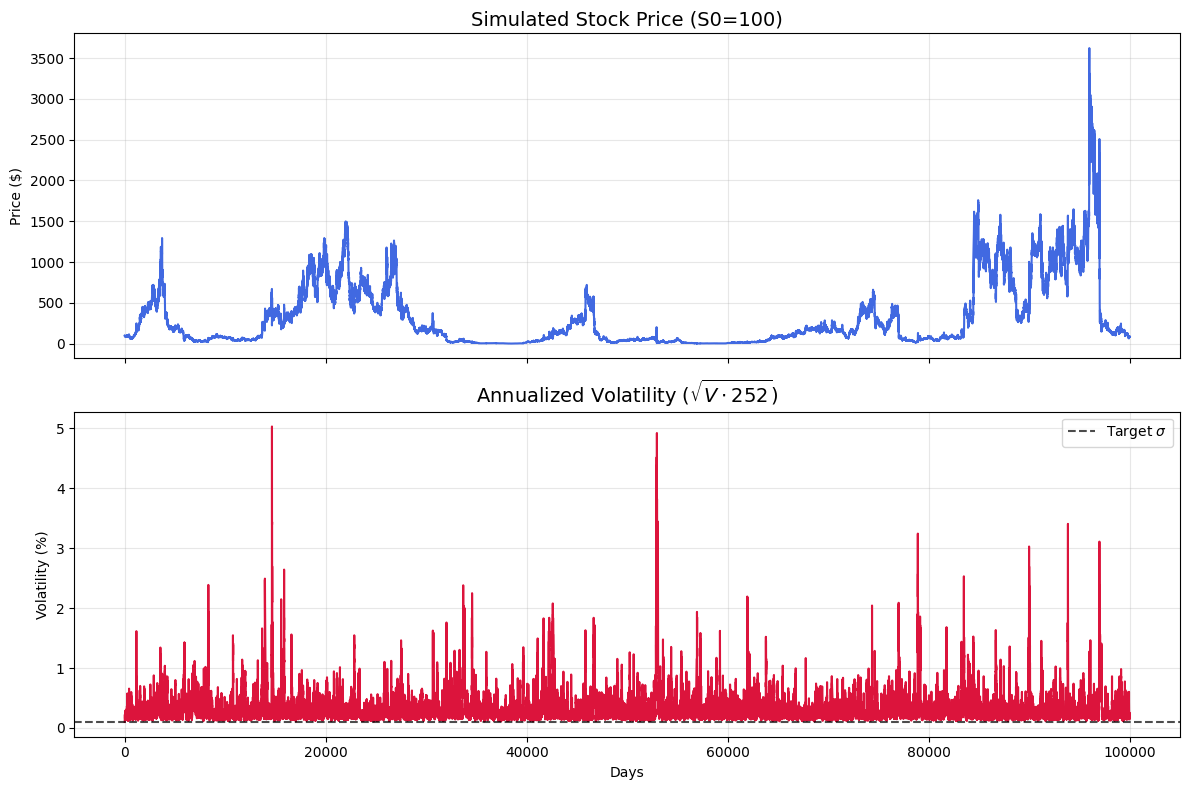

 → 77073 clean windows processed for ticker: simulated
Saved to dataset_part1.parquet, dataset_part2.parquet, dataset_part3.parquet


,ticker,date,T,sigma,z
0,simulated,4,5,0.068315,0.110758
1,simulated,9,5,0.093636,0.130488
2,simulated,14,5,0.116517,-0.266660
3,simulated,19,5,0.104192,-0.282715
4,simulated,24,5,0.182954,-0.053979
...,...,...,...,...,...
77068,simulated,99449,130,0.187303,0.187158
77069,simulated,99579,130,0.459550,-0.515983
77070,simulated,99709,130,0.205303,0.056316
77071,simulated,99839,130,0.244031,-0.363829


In [62]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Global Configuration ---
np.random.seed(42)  # Ensures the random path is identical every time you run the script

# --- 2. Model Parameters ---
sigma_annual = 0.1    # Target annualized volatility (10%)
mu_annual = 0.05      # Target annualized return (Drift)
lam = 0.79            # Decay factor (persistence of the previous day's variance)
S0 = 100              # Starting stock price
N = 100000            # Total number of simulation days
trading_days = 252    # Standardization for annualization

# --- 3. Derivative Model Components ---
# Calculate the daily variance target based on the annual input
target_V_daily = (sigma_annual**2) / trading_days

# Omega (w) is the GARCH 'Long-term weight'. 
# It pulls the variance back toward the target_V_daily (Mean Reversion)
omega = target_V_daily * (1 - lam)

# --- 4. Initialization ---
prices = [S0]
annual_vols = []
V = target_V_daily  # Initialize daily variance at the long-term target

# --- 5. Simulation Loop ---
for i in range(1, N):
    # a. Convert current daily variance to annualized volatility for logging
    current_sigma_daily = np.sqrt(V)
    annual_vols.append(current_sigma_daily * np.sqrt(trading_days))

    # b. Generate a random shock from a Standard Normal Distribution
    Z = np.random.normal(0, 1)

    # c. Calculate the Log-Return using Geometric Brownian Motion logic
    # dlogS = (mu - 0.5 * sigma^2) + sigma * Z
    log_return = (mu_annual / trading_days) - 0.5 * V + current_sigma_daily * Z
    
    # d. Update Price
    new_price = prices[-1] * np.exp(log_return)
    
    # Boundary Check: Prevent price from hitting zero/negative
    if new_price < 0.01:
        new_price = 0.01 
    prices.append(new_price)
   
    # e. Update Variance (V) using Mean Reversion + Shock logic
    # Calculate the squared percentage return as the volatility shock
    ret_sq = ((prices[-1] - prices[-2]) / prices[-2])**2

    # Formula: V_next = Anchor (Omega) + Autoregressive (Lambda * V) + Shock (Alpha * ret_sq)
    # Note: 0.01 is subtracted from alpha here to maintain stability in the sum of weights
    V = omega + (lam * V) + ((1 - lam - 0.01) * ret_sq)

    # Safety floor: Prevent variance from becoming non-positive
    V = max(V, 1e-6)

# Align the volatility list length with the price list length for plotting
annual_vols.append(annual_vols[-1])

# --- 6. Visualization ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top Plot: Price History
ax1.plot(prices, color='royalblue', linewidth=1.5)
ax1.set_title(f"Simulated Stock Price (S0={S0})", fontsize=14)
ax1.set_ylabel("Price ($)")
ax1.grid(True, alpha=0.3)

# Bottom Plot: Volatility Clustering
ax2.plot(annual_vols, color='crimson', linewidth=1.5)
# Add a horizontal line representing the long-term volatility target
ax2.axhline(y=sigma_annual, color='black', linestyle='--', alpha=0.7, label=r'Target $\sigma$')
ax2.set_title(r"Annualized Volatility ($\sqrt{V \cdot 252}$)", fontsize=14)
ax2.set_ylabel("Volatility (%)")
ax2.set_xlabel("Days")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

display(analyze_and_save_windows(prices))